# River

`River` is an open-source machine learning library for data streams. It is being developed by  **Télécom ParisTech**, **École Polytechique**, and the **University of Waikato**.

In this lab we will use `River`. Visit the page of the [library](https://riverml.xyz/) and follow the [installation instructions](https://riverml.xyz/latest/getting-started/installation/).

**Notice:** `River` requires `NumPy` and `Cython`
Also, for this lab you will need: `scikit-learn`, `pandas`, and `matplotlib`.

# Classification in Data Streams

The goal of this lab is to build a classifier capable of learning and making predictions in a datastream using the `River` library. In this lab we are comparing three datastream classifiers on Electricity dataset:
- kNN
- Hoeffding Tree
- Batch-Incremental Ensemble Classifier (BIE)

The last of the three classifiers is not implemented yet. This is the task of this lab. You should implement the `learn_one` and `predict_one` methods in the `BatchClassifier` class. 

Tasks:
1. Implement a tumbling window of size 100, creating and maintaining up to a maximum of 100 models. 
2. Build a batch `DecisionTreeClassifier` on each of the batches/windows.

**Note:** The Decision Tree is a batch model that takes as input `np.array`. You can convert dictionaries (default data type in `River`) into `np.array` with the utility method `dict2numpy` available in `river.utils` 

In [1]:
# Function to find majority element
from collections import Counter


def majority(arr):

    # convert array into dictionary
    freqDict = Counter(arr)

    # traverse dictionary and check majority element
    size = len(arr)
    for (key, val) in freqDict.items():
        if val > (size / 2):
            print(key)
            return
    print("None")

In [2]:
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from river.utils import dict2numpy
import numpy as np


class BatchClassifier:
    def __init__(self, window_size=100, max_models=100):
        self.H = []
        self.h = None
        self.window_size = window_size
        self.max_models = max_models
        self.X_batch = []
        self.y_batch = []

    def learn_one(self, x, y=None):
        # TODO
        # if not initialized ...
        # Setup
        # HINT: You can build a decision tree model on a set of data like this:
        #       h = DecisionTreeClassifier()
        #       h.fit(X_batch, y_batch)
        #       self.H.append(h) # <-- and append it to the ensemble

        self.X_batch.append(dict2numpy(x))
        self.y_batch.append(y)

        if len(self.X_batch) == self.window_size:
            h = DecisionTreeClassifier()
            h.fit(np.array(self.X_batch), self.y_batch)
            self.X_batch = []
            self.y_batch = []

            if len(self.H) == self.max_models:
                del self.H[0]
            self.H.append(h)

        return self

    def predict_one(self, x):
        # TODO
        # Be mindful of the case when the model is still empty and predictions are requested.
        # The best practice is to return a default value
        if len(self.H) != self.max_models:
            return None
        else:
            predictions = []
            for model in self.H:
                predictions.append(model.predict(dict2numpy(x).reshape(1, -1))[0])
            value, count = Counter(predictions).most_common()[0]
            return value

## Evaluation

Here we provide auxiliary functions and setup the evaluation. The `evaluate` method implements the test-then-train evaluation and tracks performance using `accuracy` and `kappa`. For each metric, two values are calculated: **prequential** (or rolling) indicates the performance of the model over a sliding window and **test-then-train** represents the performance of the model over *all* seen data from the stream. The method returns a dataframe with the results for the test calculated every `n_wait` samples (metrics are updated on every new sample). These results are used to plot performance later in the notebook.

**Note:** You do not need to modify the code in the following cell.

In [3]:
from river.tree import HoeffdingTreeClassifier
from river.neighbors import KNNClassifier
from river.stream import iter_pandas
from river import metrics
from river import utils
from tqdm.auto import tqdm

import pandas as pd

dataset = "elec"


def print_progress(sample_id, acc, kappa):
    print(f"Samples processed: {sample_id}")
    print(acc)
    print(kappa)


def evaluate(stream, model, n_wait=1000, verbose=False, total=None):
    acc = metrics.Accuracy()
    acc_rolling = utils.Rolling(metrics.Accuracy(), window_size=n_wait)
    kappa = metrics.CohenKappa()
    kappa_rolling = utils.Rolling(metrics.CohenKappa(), window_size=n_wait)
    raw_results = []
    model_name = model.__class__.__name__
    for i, (x, y) in tqdm(enumerate(stream), total=total):
        # Predict
        y_pred = model.predict_one(x)
        # Update metrics and results
        acc.update(y_true=y, y_pred=y_pred)
        acc_rolling.update(y_true=y, y_pred=y_pred)
        kappa.update(y_true=y, y_pred=y_pred)
        kappa_rolling.update(y_true=y, y_pred=y_pred)
        if i % n_wait == 0 and i > 0:
            if verbose:
                print_progress(i, acc, kappa)
            raw_results.append(
                [
                    model_name,
                    i,
                    acc.get(),
                    acc_rolling.get(),
                    kappa.get(),
                    kappa_rolling.get(),
                ]
            )
        # Learn (train)
        model.learn_one(x, y)
    print_progress(i, acc, kappa)
    return pd.DataFrame(
        raw_results, columns=["model", "id", "acc", "acc_roll", "kappa", "kappa_roll"]
    )


# Load the data, will be transformed into a stream later
df = pd.read_csv("./data/" + dataset + ".csv")
label_col = df.columns[-1]
feature_cols = list(df.columns)
feature_cols.pop()
X = df[feature_cols]
Y = df[label_col]

# Initialize models
knn = KNNClassifier(n_neighbors=10, window_size=100)
ht = HoeffdingTreeClassifier()
bie = BatchClassifier(window_size=100, max_models=100)

#### Extra points

Modify the evaluation to report training and testing time. Modify the plotting code accordingly to report processing time as well.

### Run experiments

Note that we convert the stream (`iter_pandas`) on each call to `evaluate`, this ensures that we are passing the stream properly initialized.

In [4]:
knn_results = evaluate(stream=iter_pandas(X=X, y=Y), model=knn, total=len(X))

  0%|          | 0/45311 [00:00<?, ?it/s]

Samples processed: 45310
Accuracy: 80.32%
CohenKappa: 59.58%


In [5]:
ht_results = evaluate(stream=iter_pandas(X=X, y=Y), model=ht, total=len(X))

  0%|          | 0/45311 [00:00<?, ?it/s]

Samples processed: 45310
Accuracy: 77.85%
CohenKappa: 54.00%


In [6]:
bie_results = evaluate(stream=iter_pandas(X=X, y=Y), model=bie, total=len(X))

  0%|          | 0/45311 [00:00<?, ?it/s]

Samples processed: 45310
Accuracy: 57.39%
CohenKappa: 28.24%


## Generate plots

The code below uses the raw results from the `evaluate` method to generate the plots for `accuracy` and `kappa` and generates a `pdf` file. 

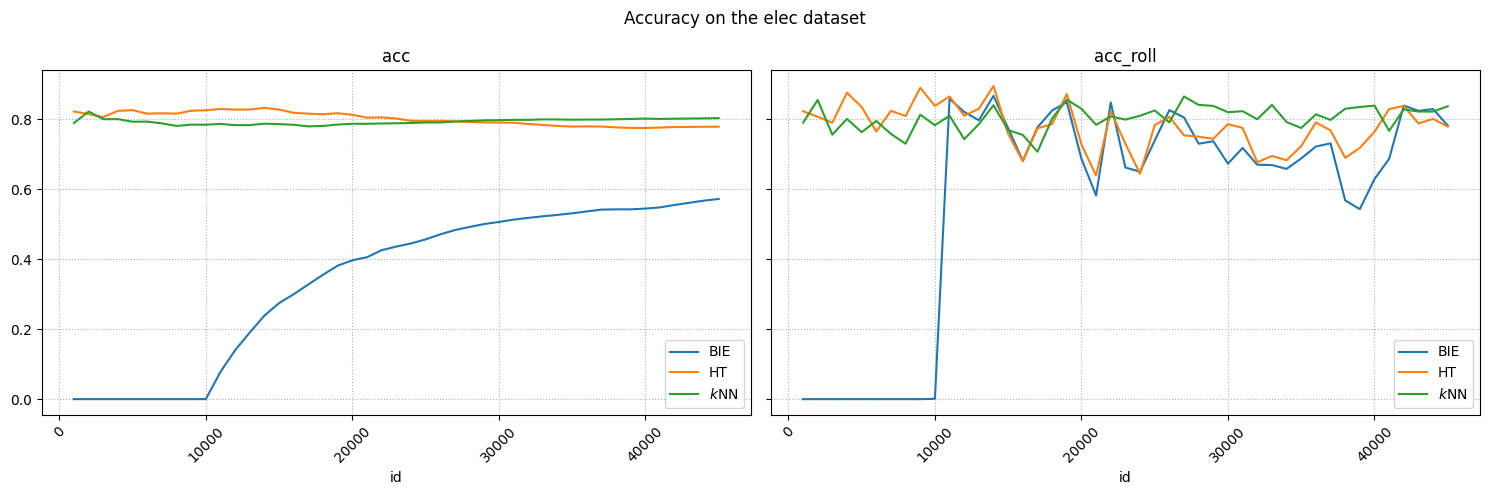

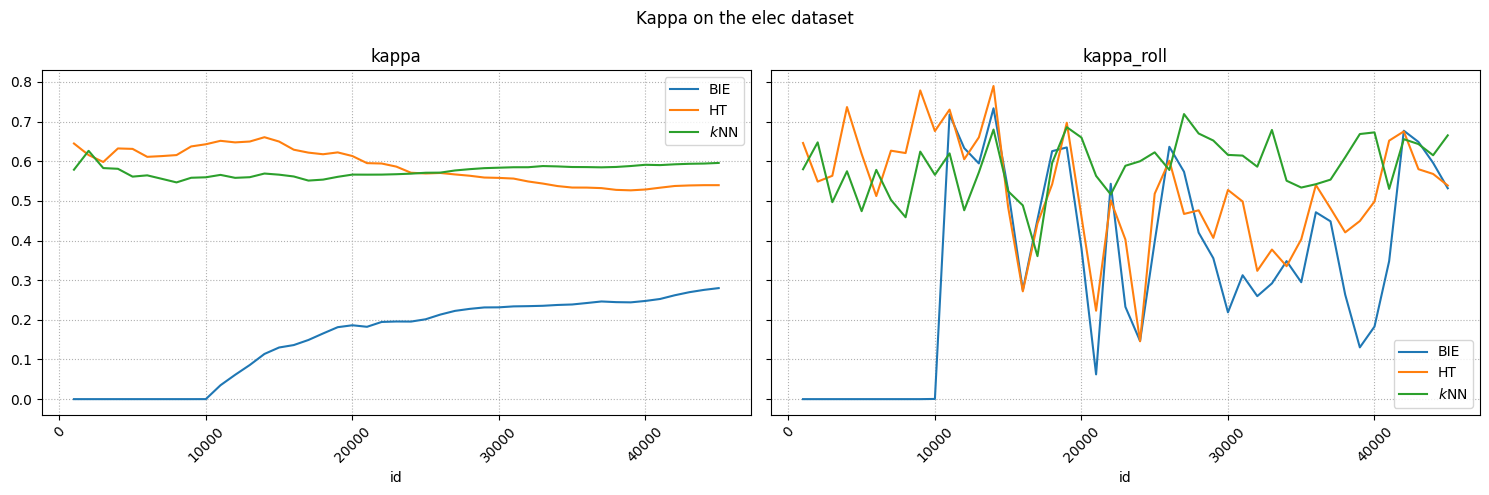

In [7]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

dataset = "elec"

df = pd.concat([knn_results, ht_results, bie_results])
df.set_index("id", inplace=True)
grouped = df.groupby("model")

with PdfPages(f"results_{dataset}.pdf") as pdf:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)
    for metric, ax in zip(["acc", "acc_roll"], axes.flatten()):
        grouped[metric].plot(rot=45, title=metric, legend=True, ax=ax)
        ax.legend(["BIE", "HT", r"$k$NN"], loc="best")
        ax.grid(linestyle=":")
    fig.suptitle("Accuracy on the %s dataset" % dataset)
    plt.tight_layout()
    pdf.savefig()  # saves the current figure into a pdf page

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)
    for metric, ax in zip(["kappa", "kappa_roll"], axes.flatten()):
        grouped[metric].plot(rot=45, title=metric, legend=True, ax=ax)
        ax.legend(["BIE", "HT", r"$k$NN"], loc="best")
        ax.grid(linestyle=":")
    fig.suptitle("Kappa on the %s dataset" % dataset)
    plt.tight_layout()
    pdf.savefig()  # saves the current figure into a pdf page

## Deliverables

You should submit:
1. The Jupyter Notebook 
2. `html` version of notebook (go to: `File/Download as/HTML`), with visible outputs of your code

in a compressed file (`.zip`, `.rar`, `tar.gz`...), and compressed file should be named: `firstname_lastname_lab2.zip`